[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Lowe_et_al_2019/fig_3.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Lowe_et_al_2019/fig_3.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Lowe_et_al_2019/fig_3.ipynb)

#### based on Fig. 3 from Lowe et al. 2019 (Nature Comm.)  "_Key drivers of cloud response to surface-active organics_"   
https://doi.org/10.1038/s41467-019-12982-0

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
from PySDM_examples.Lowe_et_al_2019 import Settings, Simulation
from PySDM_examples.Lowe_et_al_2019.aerosol_code import AerosolMarine, AerosolBoreal
from PySDM_examples.Lowe_et_al_2019.constants_def import LOWE_CONSTS

from PySDM import Formulae
from PySDM.initialisation.sampling import spectral_sampling as spec_sampling
from PySDM.physics import si

import numpy as np
import os
from joblib import Parallel, delayed, parallel_backend

In [3]:
CI = 'CI' in os.environ

nRes = 4
updraft_list = np.geomspace(0.1, 10, 2 if CI else nRes)
forg_list = np.linspace(0.05, 0.95, 2 if CI else nRes)

subplot_list = ["a","b","c","d"]
models = ('Constant', 'CompressedFilmOvadnevaite')

Acc = {"a": 30, "b": 134, "c": 160, "d": 540}

FORMULAE = Formulae(constants=LOWE_CONSTS)
WATER_MOLAR_VOLUME = FORMULAE.constants.water_molar_volume

In [5]:
def compute(key, settings):
    simulation = Simulation(settings)
    out = simulation.run()
    out['updraft'] = settings.w
    out['org_fraction'] = settings.aerosol.modes[0]['f_org']
    out['color'] = settings.aerosol.color
    return key, out

print(f'tasks scheduled: {len(models) * len(subplot_list) * len(forg_list) * len(updraft_list)}')
print(updraft_list)
with parallel_backend('threading', n_jobs=-2):
    output = dict(Parallel(verbose=0)(
        delayed(compute)(subplot+f"_w{w:.2f}_f{Forg:.2f}_"+model, Settings(
            dz = 10 * si.m if CI else 1 * si.m,
            n_sd_per_mode = 10 if CI else 50,
            model = model,
            aerosol = {
                "a": AerosolMarine(water_molar_volume=WATER_MOLAR_VOLUME, Forg=Forg, Acc_N2=Acc["a"]),
                "b": AerosolMarine(water_molar_volume=WATER_MOLAR_VOLUME, Forg=Forg, Acc_N2=Acc["b"]),
                "c": AerosolBoreal(water_molar_volume=WATER_MOLAR_VOLUME, Forg=Forg, Acc_N2=Acc["c"]),
                "d": AerosolBoreal(water_molar_volume=WATER_MOLAR_VOLUME, Forg=Forg, Acc_N2=Acc["d"])
            }[subplot],
            w = w * si.m / si.s,
            spectral_sampling = spec_sampling.ConstantMultiplicity,
        ))
        for w in updraft_list
        for Forg in forg_list
        for subplot in subplot_list
        for model in models
    ))

tasks scheduled: 128
[ 0.1         0.46415888  2.15443469 10.        ]


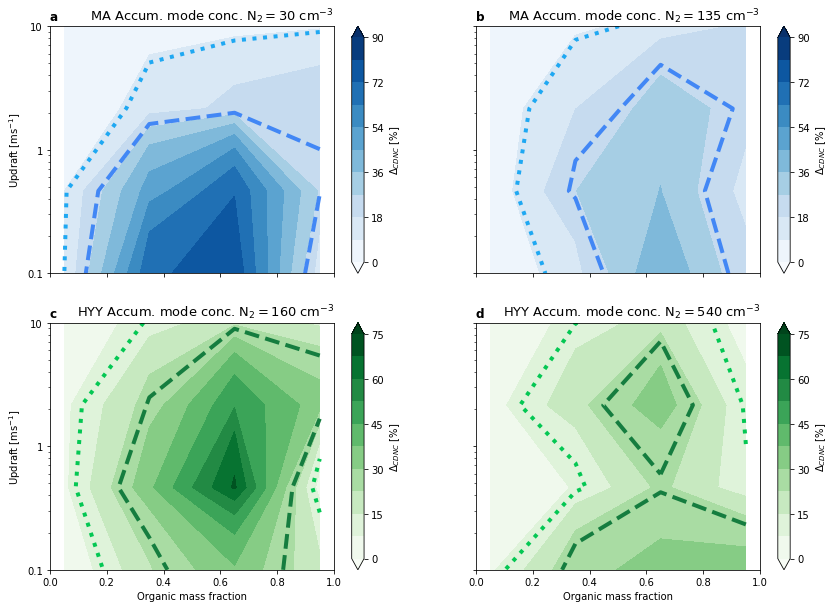

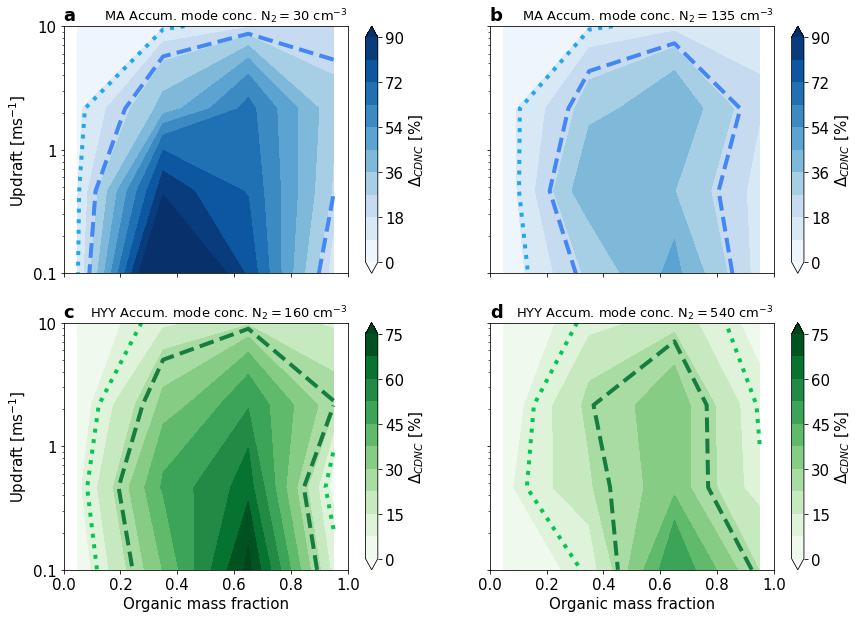

In [6]:
from PySDM_examples.Lowe_et_al_2019.plot_helper import plot_contours
plot_contours(subplot_list, updraft_list, forg_list, output, actfrac=False, save=False)
plot_contours(subplot_list, updraft_list, forg_list, output, actfrac=True, save=False)
